## Import
Nous utiliserons une stack de Data Science habituelle : `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [1]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Data/1.normalized_dataset_completed.csv")

In [3]:
df['cluster'] = 0
df.loc[df['product_category_tree'] == 'Home Furnishing', 'cluster'] = 0
df.loc[df['product_category_tree'] == 'Baby Care', 'cluster'] = 1
df.loc[df['product_category_tree'] == 'Watches', 'cluster'] = 2
df.loc[df['product_category_tree'] == 'Home Decor & Festive Needs', 'cluster'] = 3
df.loc[df['product_category_tree'] == 'Kitchen & Dining', 'cluster'] = 4
df.loc[df['product_category_tree'] == 'Beauty and Personal Care', 'cluster'] = 5
df.loc[df['product_category_tree'] == 'Computers', 'cluster'] = 6

Nous pouvons constater 7 catégories distinctives dans la segmentation des produits du dataset.

In [4]:
l_cat = list(set(df['product_category_tree']))
print("catégories : ", l_cat)

catégories :  ['Home Furnishing', 'Home Decor & Festive Needs', 'Watches', 'Kitchen & Dining', 'Beauty and Personal Care', 'Baby Care', 'Computers']


Pour notre travail de segmentation des produits nous devons simplifier la catégorisation des produits pour le modèle de Machine Learning. Nous remplaçons donc les catégories par des chiffres, plus simple à interpréter.

In [5]:
y_cat_num = []

for i in range(len(df)):
    category = df.iloc[i]['product_category_tree']
    index_of_category = l_cat.index(category)
    transformed_value = 1 - index_of_category
    y_cat_num.append(transformed_value)

Nous comptons ensuite le nombre d'occurrences de chaque mot dans le corpus avec [CountVetorizer]() qui crée un vecteur pour chaque individu.  
[fit_transform]() transforme les données en une représentation numérique plus simple à comprendre pour le modèle de Machine Learning.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

df['words'] = df['words'].astype(str)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['words'])

df_word_count = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]

In [8]:
df_tsne = pd.DataFrame({"tsne_1" : df['tsne_1'], "tsne_2" : df['tsne_2'], "cluster" : df['cluster']})

In [9]:
X = df_tsne.drop('cluster', axis=1).values

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
df_tsne['cluster_predict'] = kmeans.fit_predict(X)

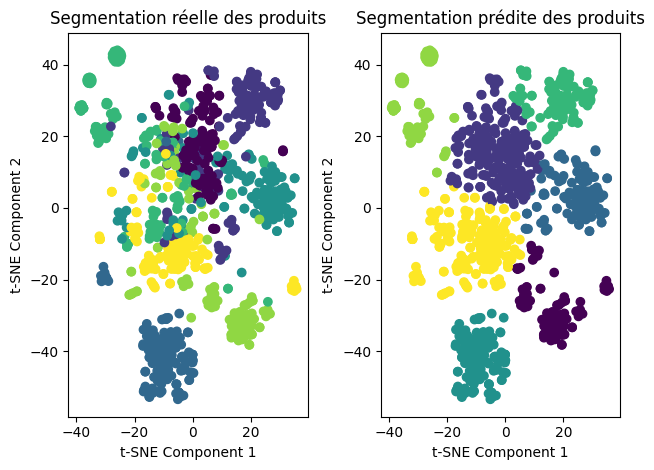

In [11]:
plt.subplot(1, 2, 1)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation réelle des produits')

plt.subplot(1, 2, 2)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['cluster_predict'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation prédite des produits')

plt.tight_layout()
plt.show()

In [12]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(df_tsne['cluster'], kmeans.labels_),4)
ARI

0.4294

In [13]:
df_tsne

,tsne_1,tsne_2,cluster,cluster_predict
0,-5.341821,36.250584,0,1
1,6.562363,4.751399,1,1
2,8.837296,4.785795,1,2
3,6.763782,37.033543,0,4
4,6.148599,37.134880,0,4
...,...,...,...,...
1045,18.290710,14.326031,1,2
1046,11.621846,-11.877667,1,0
1047,8.923777,-10.542011,1,0
1048,10.588494,-12.862549,1,0


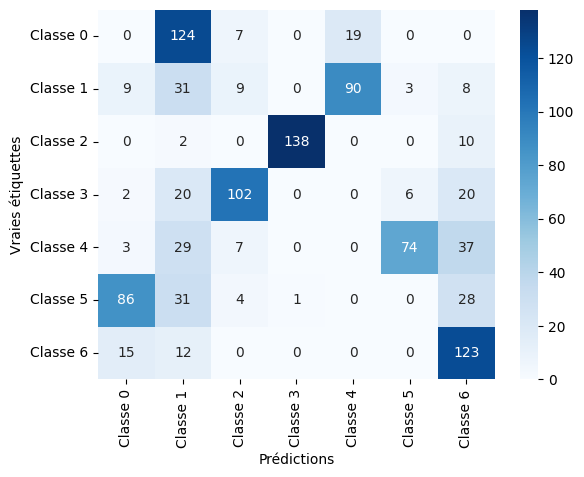

In [16]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(df_tsne['cluster'], df_tsne['cluster_predict'])
labels = [f'Classe {i}' for i in range(7)]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()
